In [1]:
# Now we've got jarret's new  selection, which involves a sliced and diced fiducial volume  in the precuts

In [1]:
%matplotlib inline
import platform
print(platform.python_version())
from ROOT import TFile,vector
import ROOT
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats

import seaborn as sns

3.5.2
Welcome to JupyROOT 6.14/08


In [2]:
def Tune1(df):
    return df['xsec_tune1_weight'].values

def CV(df):
    wgt = df['xsec_corr_weight'].values
    wgt[wgt == np.inf] = 1
    wgt = np.nan_to_num(wgt)
    wgt[wgt <= 0] = 1
    return wgt

def Spline(df):
    wgt = df['spline_weight'].values
    wgt[wgt == np.inf] = 1
    wgt = np.nan_to_num(wgt)
    wgt[wgt <= 0] = 1
    return wgt

In [3]:
def bless_leeweight(row):
    wgts_unfolded = np.array((0, 5.03093, 4.50515, 3.50515, 2.31959, 1.31959, 0.64948, 0.27835, 0.11340, 0))
    binedges_unfolded = np.array((0,.200,.250,.300,.350,.400,.450,.500,.600,.800,3.000))
    
    for i in range(0,len(wgts_unfolded)):
        if row['energyInit'] < binedges_unfolded[i+1]:
            return wgts_unfolded[i]
        
    return 0

In [4]:
def distplot(nbins,myrange,_hists,data,data_weight,stxcoord,ymax):

    fig.patch.set_alpha(1)
    vals_mc = np.zeros(nbins)

    for i in xrange(0,len(_hists)):
        v1,binedges = np.histogram(_hists[i],nbins,range=myrange,weights=a_weights[i])
        vals_mc += v1

    vals_data,_ = np.histogram(var_data,nbins,range=myrange,weights=data_weight)

    bincenters = np.diff(binedges)/2 + binedges[:-1]     
    
    plt.ylim(0,ymax)
    plt.xlim(myrange)
    ax.set_xlabel(stxcoord,fontsize=20)
    ax.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax.set_title('MCC9 Data/MC',fontsize=30)

    plt.hist(_hists,nbins,range=myrange,weights=a_weights,color=a_colors,stacked=True,linewidth=2.5,label=a_labels,edgecolor='None')
    ax.errorbar(bincenters,vals_data,fmt='.',yerr=np.sqrt(vals_data/DATA_POT*POT_SCALE_FACTOR),color='black',capsize=5,label='bnb5e19')

    ax.legend(loc='upper right',fontsize=15,frameon=False,ncol=3)
    
    print ('Events:',vals_data.sum())
    print ('MC: ',vals_mc.sum())

In [5]:
def distplot_normed(nbins,myrange,_hists,data,data_weight,stxcoord,ymax):

    fig.patch.set_alpha(1)
    vals_mc = np.zeros(nbins)

    for i in xrange(0,len(_hists)):
        v1,binedges = np.histogram(_hists[i],nbins,range=myrange,weights=a_weights[i])
        vals_mc += v1
    
    vals_data,_ = np.histogram(var_data,nbins,range=myrange,weights=data_weight,density=1)

    bincenters = np.diff(binedges)/2 + binedges[:-1]     
    
    plt.ylim(0,ymax)
    plt.xlim(myrange)
    ax.set_xlabel(stxcoord,fontsize=20)
    ax.set_ylabel('Area Normalized',fontsize=20)
    ax.set_title('MCC9 Data/MC [AREA NORMED]',fontsize=30)

    plt.hist(_hists,nbins,range=myrange,weights=a_weights,color=a_colors,stacked=True,linewidth=2.5,label=a_labels,density=1,edgecolor='None')
    ax.errorbar(bincenters,vals_data,fmt='.',yerr=np.sqrt(vals_data/DATA_POT*POT_SCALE_FACTOR),color='black',capsize=5,label='bnb5e19')
    
    ax.legend(loc='upper right',fontsize=15,frameon=False)
    print ('Events:',vals_data.sum())

In [6]:
def distplot_wratio(nbins,myrange,_hists,data,data_weight,stxcoord,ymax,writepval=False):

    fig.patch.set_alpha(1)
    vals_mc = np.zeros(nbins)
    yerr_mc = np.zeros(nbins)
    
    a_labels_evts = []
    
    print(len(_hists),len(a_weights))
    
    for i in range(0,len(_hists)):
        v1,binedges = np.histogram(_hists[i],nbins,range=myrange,weights=a_weights[i])
        yerr_mc += v1*a_scale[i]
        vals_mc += v1
        a_labels_evts.append(a_labels[i]+' (%.2f)'%v1.sum())
    
    yerr_mc = np.sqrt(yerr_mc)
        
    vals_data,_ = np.histogram(data,nbins,range=myrange,weights=data_weight)
    bincenters = np.diff(binedges)/2 + binedges[:-1]     
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.set_ylim(0,ymax)
    ax0.set_xlim(myrange)
    ax1.set_ylim(0,2)
    ax1.set_xlim(myrange)
    ax1.set_xlabel(stxcoord,fontsize=20)
    ax0.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax1.set_ylabel('Data/MC',fontsize=20)
    ax0.set_title('MCC9 Data/MC',fontsize=30)

    ax0.hist(_hists,nbins,range=myrange,weights=a_weights,color=a_colors,stacked=True,linewidth=0,label=a_labels_evts,edgecolor=None)
    ax0.errorbar(bincenters,vals_data,fmt='.',yerr=np.sqrt(vals_data/DATA_POT*POT_SCALE_FACTOR),color='black',capsize=5,label='bnb5e19 (%i)'%vals_data.sum())
    
    ax0.legend(loc='upper right',fontsize=15,frameon=False,ncol=3)
    
    er_rat = np.sqrt(np.power(np.divide(yerr_mc,vals_mc),2) + np.power(np.divide(np.sqrt(vals_data),vals_data),2)) * np.true_divide(vals_data,vals_mc)

    chisq = np.power(np.true_divide(np.true_divide(vals_data,vals_mc)-np.ones(len(er_rat)),er_rat),2).sum()
    pval = 1 - stats.chi2.cdf(chisq, len(er_rat)) 
    
    
    ax1.errorbar(bincenters,np.true_divide(vals_data,vals_mc),yerr=er_rat,fmt='o',color='maroon',capsize=0)
    ax1.axhline(1,color='maroon',linestyle=':')
    ax0.annotate(r'$\sum$data/$\sum$MC = %.2f'%(vals_data.sum()/float(vals_mc.sum())),xy=(.01,.92),xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))
    
    if writepval:
        ax1.annotate('p-value: %.3f\n'%pval+r'$\chi^2/dof$: %.3f'%(chisq/float(len(er_rat))),xy=(.85,.7), xycoords='axes fraction',fontsize=15,bbox=dict(boxstyle="round4", fc="w",alpha=.9))

    
    plt.tight_layout()
    print ('Events:',vals_data.sum())
    print ('MC: ',vals_mc.sum())
    return ax0

In [7]:
NUMU_POT = 4.71579e+20
NUE_POT  = 9.80259e+22
DIRT_POT = 2.61947e+20
DATA_POT = 4.403e+19
EXT_POT = (22474918.0) / float ( 9776965.0) * DATA_POT # 14542235.0 / 10640228.0 * DATA_POT

POT_SCALE_FACTOR = 13e+20

NUMU_SCALE = POT_SCALE_FACTOR / float(NUMU_POT)
NUE_SCALE = POT_SCALE_FACTOR / float(NUE_POT)
EXT_SCALE = POT_SCALE_FACTOR / float(EXT_POT)
DATA_SCALE = POT_SCALE_FACTOR / float(DATA_POT)
DIRT_SCALE = POT_SCALE_FACTOR / float(DIRT_POT)

## Load things up

In [8]:
# Or, we can load from pickles if you, you know, want to.
# Pickle read for easy access later, eh?
tag = 'Mar_26_shower'
df_data_goodruns_pmtprecut = pd.read_pickle('data/pickles/data_goodruns_precuts_%s.pickle'%tag)
df_numu_goodruns_pmtprecut = pd.read_pickle('data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
df_nue_goodruns_pmtprecut = pd.read_pickle('data/pickles/nue_goodruns_precuts_%s.pickle'%tag)
df_ext_goodruns_pmtprecut = pd.read_pickle('data/pickles/ext_goodruns_precuts_%s.pickle'%tag)
df_dirt_goodruns_pmtprecut = pd.read_pickle('data/pickles/dirt_goodruns_precuts_%s.pickle'%tag)
print (len(df_ext_goodruns_pmtprecut))

6152


In [9]:
# df_nue_goodruns_pmtprecut.insert(0,'leeweight',df_nue_goodruns_pmtprecut.apply(bless_leeweight,axis=1))

In [10]:
# print (len(df_nue_goodruns_pmtprecut)*NUE_SCALE)
# print (len(df_nue_goodruns_pmtprecut.query('PassCuts==1'))*NUE_SCALE)
# print (len(df_nue_goodruns_pmtprecut.query('PassCuts==1 and PassShowerReco == 1'))*NUE_SCALE)
# print (len(df_nue_goodruns_pmtprecut.query('PassCuts==1 and PassShowerReco == 1 and PassSecShr == 1'))*NUE_SCALE)


# After simple fiducial and containment cuts

In [11]:
cuts = 'PassPMTPrecut==1 and NTracks >=1 and InFiducial ==1'
df_numu_presel = df_numu_goodruns_pmtprecut.query(cuts)
df_nue_presel = df_nue_goodruns_pmtprecut.query(cuts)
df_ext_presel = df_ext_goodruns_pmtprecut.query(cuts)
df_data_presel = df_data_goodruns_pmtprecut.query(cuts)
df_dirt_presel = df_dirt_goodruns_pmtprecut.query(cuts)

weights_numu_presel = df_numu_presel['xsec_tune1_weight'].values*NUMU_SCALE
weights_nue_presel = df_nue_presel['xsec_tune1_weight'].values*NUE_SCALE
weights_ext_presel = np.ones(len(df_ext_presel))*EXT_SCALE
weights_data_presel = np.ones(len(df_data_presel))*DATA_SCALE
weights_dirt_presel = CV(df_dirt_presel)*DIRT_SCALE
#weights_lee_presel = df_nue_presel['leeweight'].values * df_nue_presel['geniereweight'].values * NUE_SCALE

In [12]:
a_weights = [weights_numu_presel,weights_nue_presel,weights_dirt_presel,weights_ext_presel]
a_scale = [NUMU_SCALE,NUE_SCALE,DIRT_SCALE,EXT_SCALE]
a_labels = ['Numu Overlay','Nue Intrinsic Overlay','Joe Dirt','EXTBNB']
a_colors = ['mediumspringgreen','c','brown','mediumorchid']

4 4
Events: 250020.44060867632
MC:  239630.57845013266


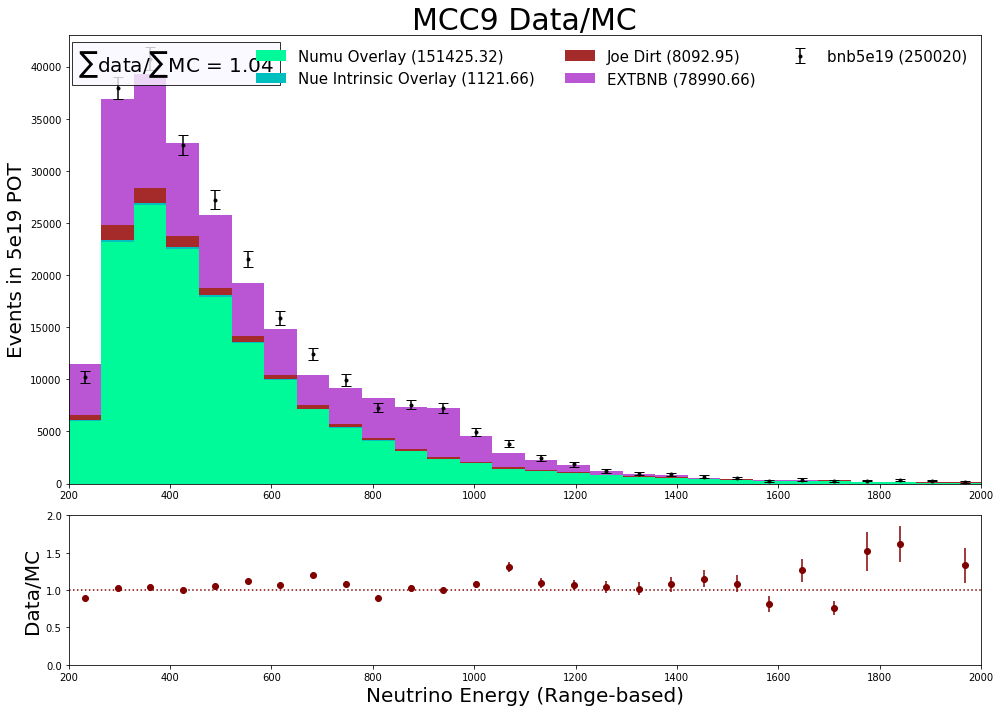

In [13]:
var_numu = df_numu_presel['Enu_1m1p'].values
var_nue = df_nue_presel['Enu_1m1p'].values
var_ext = df_ext_presel['Enu_1m1p'].values
var_data = df_data_presel['Enu_1m1p'].values
var_dirt = df_dirt_presel['Enu_1m1p'].values

# fig,ax = plt.subplots(figsize=(14,10))
# ax0 = distplot_wratio(28,(200,2000),[var_numu,var_nue,var_ext],var_data,weights_data_presel,'Neutrino Energy (Range-based)',.8e3)
# ax0.annotate('Fiducial, Two-Track, Containment\nCuts, Succesful Shower Reco and \nSimple Second Shower Cuts Applied',xy=(.6,.7), xycoords='axes fraction',fontsize=15)
# #ax.annotate('6808 Events in 5e19',xy=(.7,.6), xycoords='axes fraction',fontsize=20)

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(28,(200,2000),[var_numu,var_nue,var_dirt,var_ext],var_data,weights_data_presel,'Neutrino Energy (Range-based)',43000)
# ax0.annotate('Fiducial, Two-Track, Containment\nCuts, Succesful Shower Reco and \nSimple Second Shower Cuts Applied',xy=(.6,.7), xycoords='axes fraction',fontsize=15)
#ax.annotate('6808 Events in 5e19',xy=(.7,.6), xycoords='axes fraction',fontsize=20)



In [15]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
cols = df_numu_presel.columns.tolist()
print(cols)

# pi0cuts = '_pi0mass>0 and (shower1_dir_2d_Y < (3.14-.5) or shower1_dir_2d_Y >(3.14+.5) ) and (shower2_dir_2d_Y < (3.14-.5)or shower2_dir_2d_Y > (3.14+.5) )'
pi0cuts = '_pi0mass>0'
df_numu_pi0 = df_numu_presel.query(pi0cuts)
df_nue_pi0 = df_nue_presel.query(pi0cuts)
df_ext_pi0 = df_ext_presel.query(pi0cuts)
df_data_pi0 = df_data_presel.query(pi0cuts)
df_dirt_pi0 = df_dirt_presel.query(pi0cuts)

weights_numu_pi0 = df_numu_pi0['xsec_tune1_weight'].values*NUMU_SCALE
weights_nue_pi0 = df_nue_pi0['xsec_tune1_weight'].values*NUE_SCALE
weights_ext_pi0 = np.ones(len(df_ext_pi0))*EXT_SCALE
weights_data_pi0 = np.ones(len(df_data_pi0))*DATA_SCALE
weights_dirt_pi0 = np.ones(len(df_dirt_pi0))*DIRT_SCALE
#weights_lee_presel = df_nue_presel['leeweight'].values * df_nue_presel['geniereweight'].values * NUE_SCALE

['mc_label', 'xsec_tune1_weight', 'run', 'subrun', 'event', 'vtxid', 'Xreco', 'Yreco', 'Zreco', 'InFiducial', 'AnyReco', 'NTracks', 'N5cmTracks', 'PassSimpleCuts', 'PassShowerReco', 'PassSecondShower', 'FailedBoost', 'Good3DReco', 'Eta', 'OpenAng', 'Thetas', 'Phis', 'ChargeNearTrunk', 'LongTrackLen', 'ShortTrackLen', 'MaxShrFrac', 'MinShrFrac', 'CCQEEnergyShift_1m1p', 'Enu_1m1p', 'PhiT_1m1p', 'AlphaT_1m1p', 'PT_1m1p', 'PTRat_1m1p', 'BjX_1m1p', 'BjY_1m1p', 'Q2_1m1p', 'Sph_1m1p', 'PzEnu_1m1p', 'Q0_1m1p', 'Q3_1m1p', 'OpenAngB_1m1p', 'ThetasB_1m1p', 'PhisB_1m1p', 'PhiTB_1m1p', 'AlphaTB_1m1p', 'PTB_1m1p', 'BjXB_1m1p', 'BjYB_1m1p', 'Q2B_1m1p', 'SphB_1m1p', 'CCQEEnergyShift_1e1p', 'Enu_1e1p', 'PhiT_1e1p', 'AlphaT_1e1p', 'PT_1e1p', 'PTRat_1e1p', 'BjX_1e1p', 'BjY_1e1p', 'Q2_1e1p', 'Sph_1e1p', 'PzEnu_1e1p', 'Q0_1e1p', 'Q3_1e1p', 'OpenAngB_1e1p', 'ThetasB_1e1p', 'PhisB_1e1p', 'PhiTB_1e1p', 'AlphaTB_1e1p', 'PTB_1e1p', 'BjXB_1e1p', 'BjYB_1e1p', 'Q2B_1e1p', 'SphB_1e1p', 'Lepton_ID', 'Lepton_PhiReco'

In [43]:
df_numu_CCQE_pi0 = df_numu_pi0.query("mc_label in ['numu_CCQE']")
df_numu_MEC_pi0 = df_numu_pi0.query("mc_label in ['numu_MEC']")
df_numu_pizero_pi0 = df_numu_pi0.query("mc_label in ['numu_pizero']")
df_numu_piplusminus_pi0= df_numu_pi0.query("mc_label in ['numu_piplusminus']")
df_bnb_other_pi0 = df_numu_pi0.query("mc_label not in ['nue_offvtx','numu_offvtx','numu_CCQE','numu_MEC','numu_pizero','numu_piplusminus']")
df_nue_CC_pi0 = df_nue_pi0.query("mc_label not in ['nue_offvtx']")

df_numu_offvtx_pi0 = df_numu_pi0.query("mc_label in ['numu_offvtx'] and mc_label in ['numu_pizero']")
df_nue_offvtx_pi0= df_nue_pi0.query("mc_label in ['nue_offvtx'] and mc_label not in ['numu_pizero'] ")
df_bnb_offvtx_pi0 = pd.concat([df_numu_offvtx_pi0,df_nue_offvtx_pi0],sort=False)

df_numu_offvtx_nonpi0 = df_numu_pi0.query("mc_label in ['numu_offvtx'] and mc_label not in ['numu_pizero']")
df_nue_offvtx_nonpi0= df_nue_pi0.query("mc_label in ['nue_offvtx'] and mc_label not in ['numu_pizero'] ")
df_bnb_offvtx_nonpi0 = pd.concat([df_numu_offvtx_nonpi0,df_nue_offvtx_nonpi0],sort=False)


weights_bnb_offvtx_pi0 = np.concatenate((CV(df_numu_offvtx_pi0)*NUMU_SCALE,CV(df_nue_offvtx_pi0)*NUE_SCALE))
weights_bnb_offvtx_nonpi0 = np.concatenate((CV(df_numu_offvtx_nonpi0)*NUMU_SCALE,CV(df_nue_offvtx_nonpi0)*NUE_SCALE))
# weights_bnb_offvtx_pi0 = CV(df_bnboverlay_offvtx_pi0)*NUMU_SCALE
weights_numu_CCQE_pi0 = CV(df_numu_CCQE_pi0)*NUMU_SCALE
weights_numu_MEC_pi0 = CV(df_numu_MEC_pi0)*NUMU_SCALE
weights_numu_pizero_pi0 = CV(df_numu_pizero_pi0)*NUMU_SCALE
weights_numu_piplusminus_pi0 = CV(df_numu_piplusminus_pi0)*NUMU_SCALE
weights_bnb_other_pi0 = CV(df_bnb_other_pi0)*NUMU_SCALE
weights_nue_CC_pi0 = CV(df_nue_CC_pi0)*NUE_SCALE
weights_ext_pi0 = np.ones(len(df_ext_pi0))*EXT_SCALE
weights_data_pi0 = np.ones(len(df_data_pi0))*DATA_SCALE
weights_dirt_pi0 = CV(df_dirt_pi0)*DIRT_SCALE

a_weights = [weights_numu_CCQE_pi0,weights_numu_MEC_pi0,weights_numu_pizero_pi0,weights_numu_piplusminus_pi0,weights_bnb_other_pi0,weights_bnb_offvtx_pi0,weights_bnb_offvtx_nonpi0,weights_nue_CC_pi0,weights_dirt_pi0,weights_ext_pi0]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,DIRT_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'BNB Other','BNB Off Vertex pi0','BNB Off Vertex nonpi0',r'$\nu_e$ Intrinsic Overlay','Dirt','EXTBNB']
a_colors = ['blue','cyan','greenyellow','darkgreen','gold','grey','red','pink','peru','fuchsia']


print(len(a_colors))

10



22048
22048
10 10


ValueError: weights should have the same shape as a.

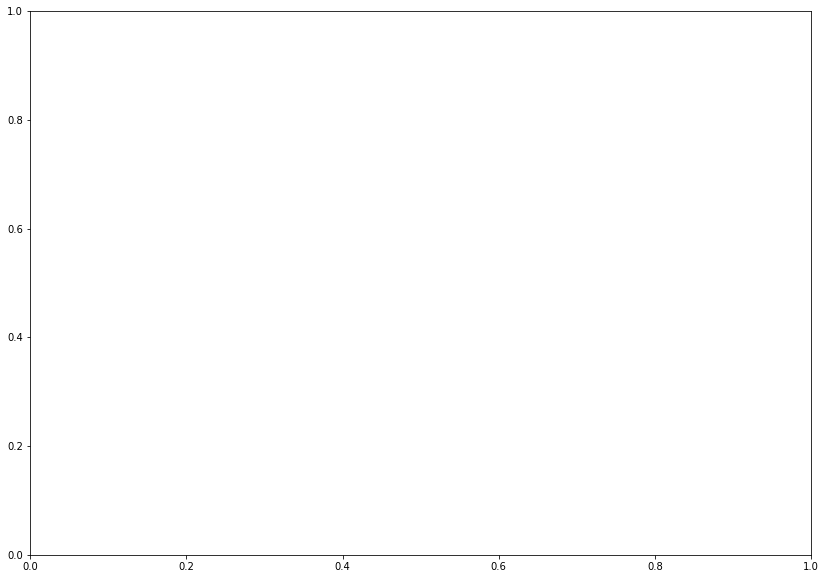

In [44]:
vartest = 'Enu_1m1p'
varname = r'Reconstructed $E_\nu$'
myrange = (50,1500)
nbins = 60
print()
# vtx_offvtx = np.concatenate((CV(df_bnboverlay_offvtx_presel[vartest].values),CV(df_nue_offvtx_presel[vartest].values)))
var_offvtx = df_bnb_offvtx_pi0[vartest].values
var_offvtx_non = df_bnb_offvtx_nonpi0[vartest].values
var_ccqe = df_numu_CCQE_pi0[vartest].values
var_mec = df_numu_MEC_pi0[vartest].values
var_pizero = df_numu_pizero_pi0[vartest].values
var_piplusminus = df_numu_piplusminus_pi0[vartest].values
var_other = df_bnb_other_pi0[vartest].values
var_nue = df_nue_CC_pi0[vartest].values
var_ext = df_ext_pi0[vartest].values
var_data = df_data_pi0[vartest].values
var_dirt = df_dirt_pi0[vartest].values

print (len(var_offvtx_non))
print (len(weights_bnb_offvtx_nonpi0))

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_offvtx_non,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_pi0,varname,1800)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)



131.14941
135.11186
10 10
Events: 12666.363842834427
MC:  14473.117696977992


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


Text(0.75, 0.6, 'Fiducial, Two-Track,and \nContainment Cuts Applied')

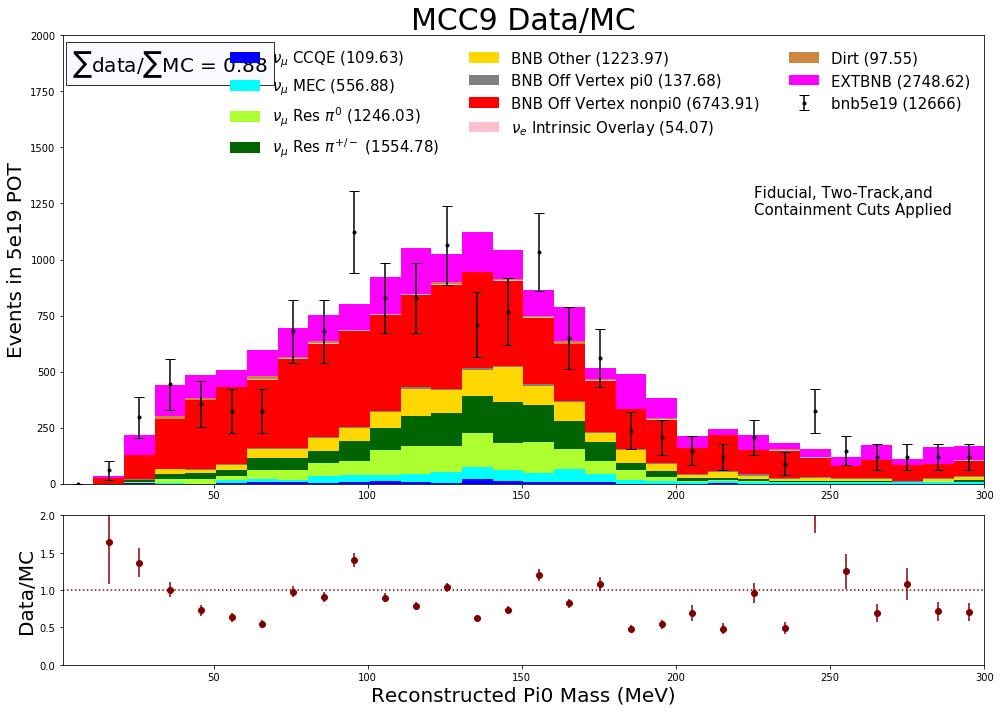

In [45]:
vartest = '_pi0mass'
varname = r'Reconstructed Pi0 Mass (MeV)'
myrange = (1,300)
nbins = 30

var_offvtx = df_bnb_offvtx_pi0[vartest].values
var_ccqe = df_numu_CCQE_pi0[vartest].values
var_mec = df_numu_MEC_pi0[vartest].values
var_pizero = df_numu_pizero_pi0[vartest].values
var_piplusminus = df_numu_piplusminus_pi0[vartest].values
var_other = df_bnb_other_pi0[vartest].values
var_nue = df_nue_CC_pi0[vartest].values
var_ext = df_ext_pi0[vartest].values
var_data = df_data_pi0[vartest].values
var_dirt = df_dirt_pi0[vartest].values
var_offvtx_non = df_bnb_offvtx_nonpi0[vartest].values

print(mean(var_pizero))
print(mean(var_piplusminus))

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_offvtx_non,var_nue,var_dirt,var_ext],var_data,weights_data_pi0,varname,2000)
# ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_ext],var_ext,weights_ext_presel,varname,1000)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

9 9
Events: 14231.205995911874
MC:  16348.592451375338


Text(0.75, 0.6, 'Fiducial, Two-Track,and \nContainment Cuts Applied')

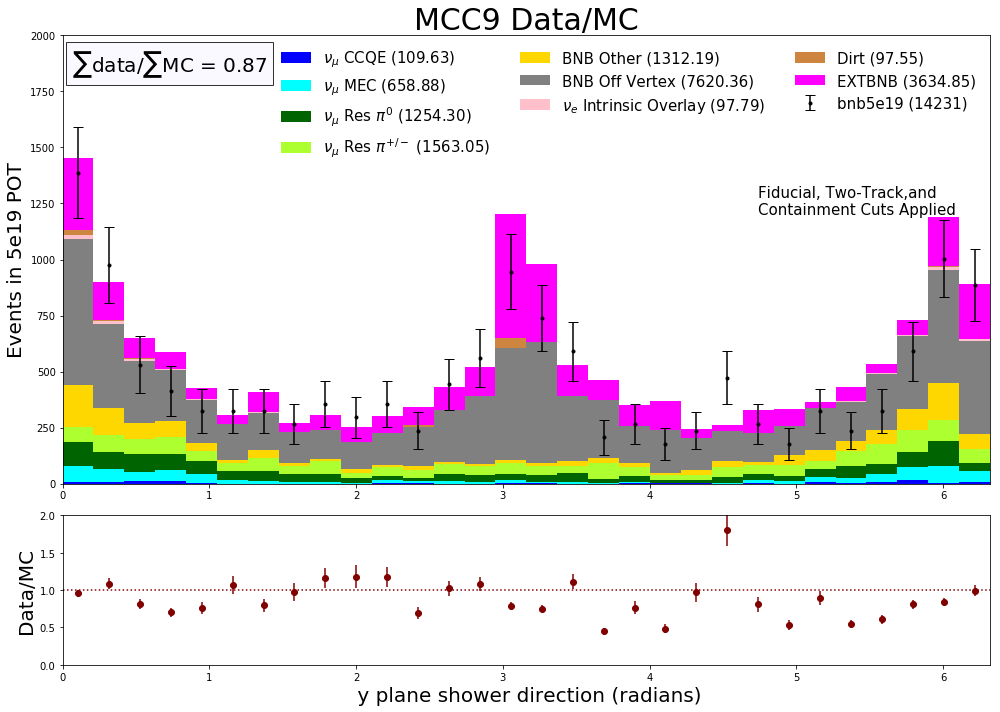

In [23]:
vartest = 'shower1_dir_2d_Y'
varname = r' y plane shower direction (radians)'
myrange = (0,2*3.16)
nbins = 30

var_offvtx = df_bnb_offvtx_pi0[vartest].values
var_ccqe = df_numu_CCQE_pi0[vartest].values
var_mec = df_numu_MEC_pi0[vartest].values
var_pizero = df_numu_pizero_pi0[vartest].values
var_piplusminus = df_numu_piplusminus_pi0[vartest].values
var_other = df_bnb_other_pi0[vartest].values
var_nue = df_nue_CC_pi0[vartest].values
var_ext = df_ext_pi0[vartest].values
var_data = df_data_pi0[vartest].values
var_dirt = df_dirt_pi0[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_pi0,varname,2000)
# ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_ext],var_ext,weights_ext_presel,varname,1000)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

9 9
Events: 14349.307290483755
MC:  16330.675289385994


Text(0.75, 0.6, 'Fiducial, Two-Track,and \nContainment Cuts Applied')

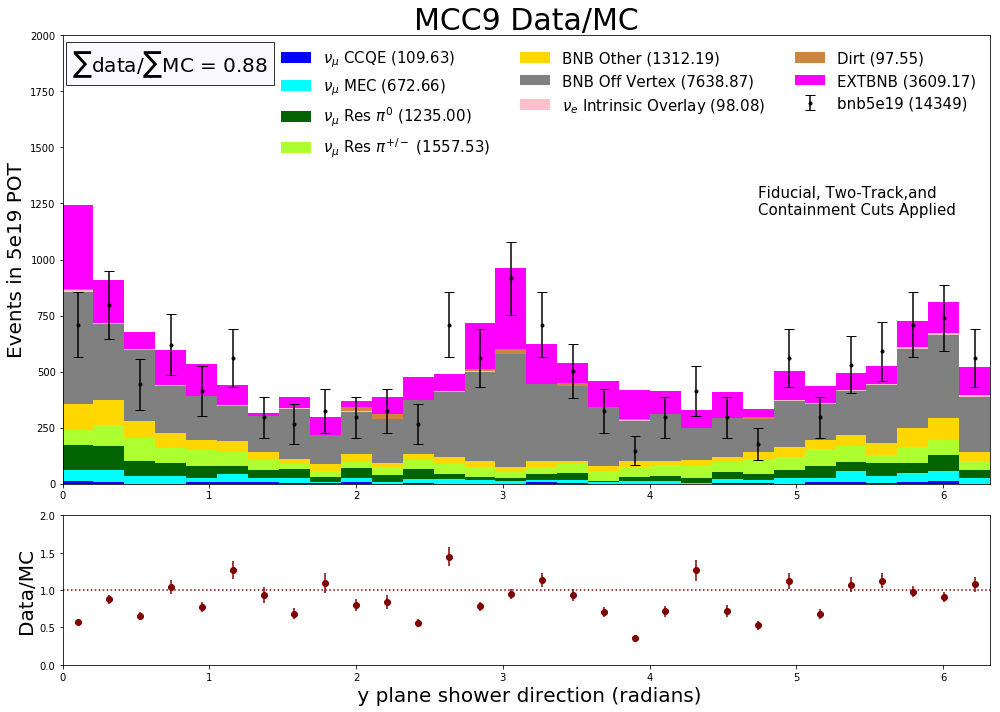

In [24]:
vartest = 'shower2_dir_2d_Y'
varname = r' y plane shower direction (radians)'
myrange = (0,2*3.16)
nbins = 30

var_offvtx = df_bnb_offvtx_pi0[vartest].values
var_ccqe = df_numu_CCQE_pi0[vartest].values
var_mec = df_numu_MEC_pi0[vartest].values
var_pizero = df_numu_pizero_pi0[vartest].values
var_piplusminus = df_numu_piplusminus_pi0[vartest].values
var_other = df_bnb_other_pi0[vartest].values
var_nue = df_nue_CC_pi0[vartest].values
var_ext = df_ext_pi0[vartest].values
var_data = df_data_pi0[vartest].values
var_dirt = df_dirt_pi0[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_pi0,varname,2000)
# ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_ext],var_ext,weights_ext_presel,varname,1000)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

167.73933
9 9


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


Events: 14467.40858505564
MC:  16460.706442092443


Text(0.75, 0.6, 'Fiducial, Two-Track,and \nContainment Cuts Applied')

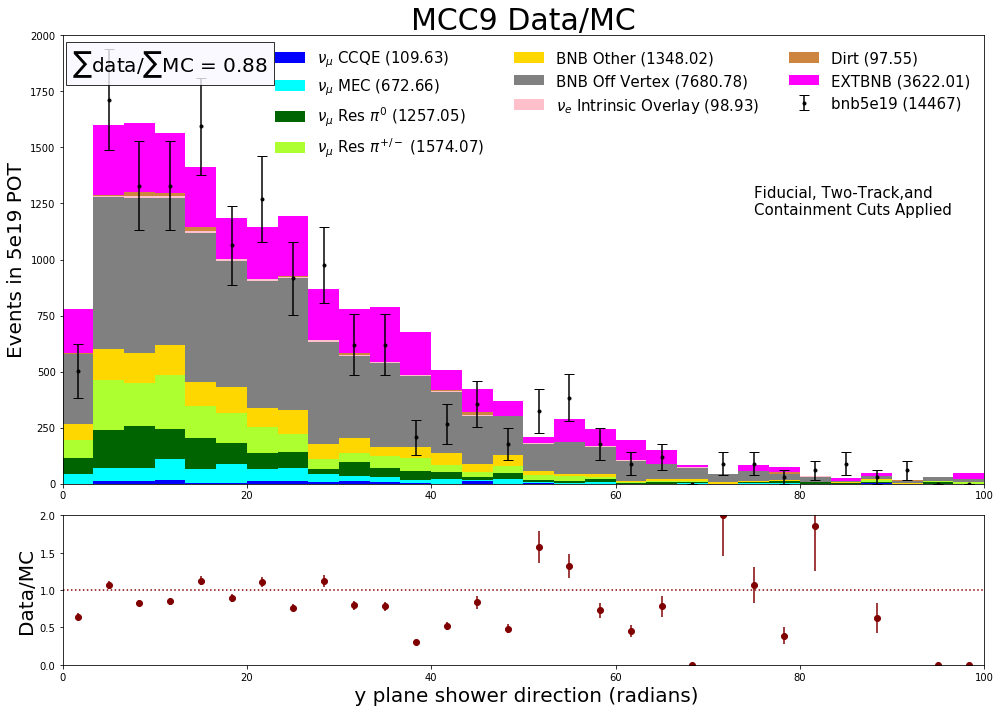

In [22]:
vartest = '_shower2_impact'
varname = r' y plane shower direction (radians)'
myrange = (0,100)
nbins = 30

var_offvtx = df_bnb_offvtx_pi0[vartest].values
var_ccqe = df_numu_CCQE_pi0[vartest].values
var_mec = df_numu_MEC_pi0[vartest].values
var_pizero = df_numu_pizero_pi0[vartest].values
var_piplusminus = df_numu_piplusminus_pi0[vartest].values
var_other = df_bnb_other_pi0[vartest].values
var_nue = df_nue_CC_pi0[vartest].values
var_ext = df_ext_pi0[vartest].values
var_data = df_data_pi0[vartest].values
var_dirt = df_dirt_pi0[vartest].values

print(max(var_data))

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_pi0,varname,2000)
# ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_ext],var_ext,weights_ext_presel,varname,1000)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

# Apply Selection

In [12]:
# We're doing things different now! Load up the weights themselves.
with open('/home/dcianci/Physics/1e1p/1mu1pSelection/bdtweight_1e1p_vNov6_fullrange.pickle','rb') as handle: [cosmicBDT,pi0BDT,nubkgBDT] = pickle.load(handle)          # Load BDT weights for 1e1p background differentiation

selecvars_v1 = ['pTRat_1e1p','bjX_1e1p','eta','longtracklen','shorttracklen','Proton_ThetaReco','Lepton_ThetaReco','Proton_PhiReco','Lepton_PhiReco','maxshrFrac','minshrFrac','sph_1e1p','pzEnu_1e1p','bjY_1e1p','openAng','Proton_Edep','Electron_Edep','Muon_Edep']
jarretvars_v2 = ['Proton_ThetaReco','Lepton_ThetaReco','Eta','BjXB_1e1p','BjYB_1e1p','OpenAng','PzEnu_1e1p','PT_1e1p','PTRat_1e1p','Sph_1e1p','Enu_1e1p','MaxShrFrac','MinShrFrac','ChargeNearTrunk','CCQEEnergyShift_1e1p']

myvars = jarretvars_v2

In [13]:
df_numu_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_numu_presel[myvars].values.tolist(),output_margin=True))
df_nue_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_nue_presel[myvars].values.tolist(),output_margin=True))
df_ext_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_ext_presel[myvars].values.tolist(),output_margin=True))
df_data_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_data_presel[myvars].values.tolist(),output_margin=True))

In [14]:
df_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_numu_presel[myvars].values.tolist(),output_margin=True))
df_nue_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_nue_presel[myvars].values.tolist(),output_margin=True))
df_ext_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_ext_presel[myvars].values.tolist(),output_margin=True))
df_data_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_data_presel[myvars].values.tolist(),output_margin=True))

In [15]:
df_numu_presel.insert(0,'Pi0BkgScore',pi0BDT.predict(df_numu_presel[myvars].values.tolist(),output_margin=True))
df_nue_presel.insert(0,'Pi0BkgScore',pi0BDT.predict(df_nue_presel[myvars].values.tolist(),output_margin=True))
df_ext_presel.insert(0,'Pi0BkgScore',pi0BDT.predict(df_ext_presel[myvars].values.tolist(),output_margin=True))
df_data_presel.insert(0,'Pi0BkgScore',pi0BDT.predict(df_data_presel[myvars].values.tolist(),output_margin=True))

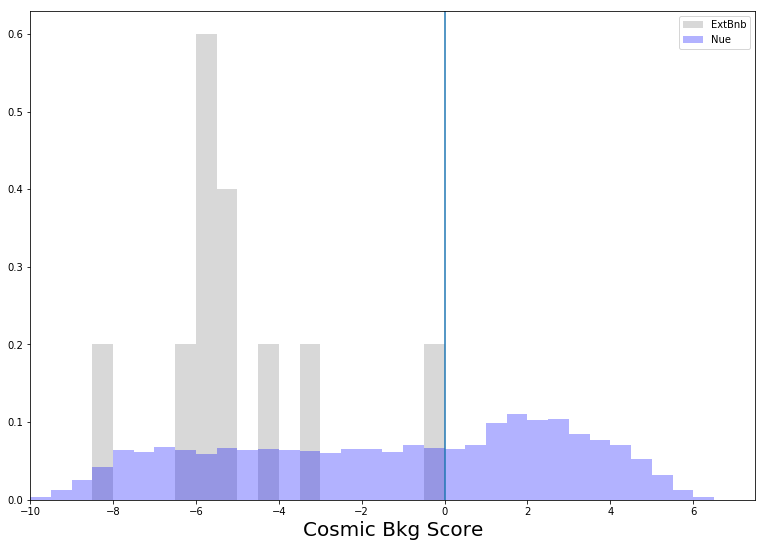

In [16]:
#Plot bdt variables

cosbkg_ext = df_ext_presel.query('BDTprob > .5')['CosBkgScore'].values
cosbkg_nue = df_nue_presel.query('BDTprob > .5')['CosBkgScore'].values

fig,ax = plt.subplots(figsize=(13,9))
nbins = 40
myrange = (-10,10)

plt.hist(cosbkg_ext,nbins,range=myrange,color='gray',alpha=.3,density=True,label='ExtBnb')
plt.hist(cosbkg_nue,nbins,range=myrange,color='blue',alpha=.3,density=True,label='Nue')

ax.set_xlabel('Cosmic Bkg Score',fontsize=20)
ax.axvline(0)
ax.set_xlim(-10,7.5)

plt.legend()

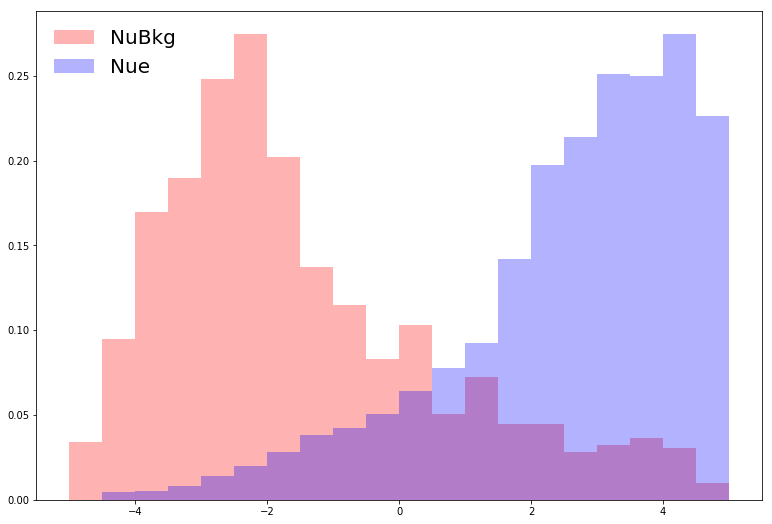

In [17]:
#Plot bdt variables

nubkg_numu = df_numu_presel.query('CosBkgScore > 2')['NuBkgScore'].values
nubkg_nue = df_nue_presel.query('CosBkgScore > 2')['NuBkgScore'].values

fig,ax = plt.subplots(figsize=(13,9))
nbins = 20
myrange = (-5,5)

plt.hist(nubkg_numu,nbins,range=myrange,color='red',alpha=.3,density=True,label='NuBkg')
plt.hist(nubkg_nue,nbins,range=myrange,color='blue',alpha=.3,density=True,label='Nue')

plt.legend(fontsize=20)

_ = plt.legend(fontsize=20,frameon=False)

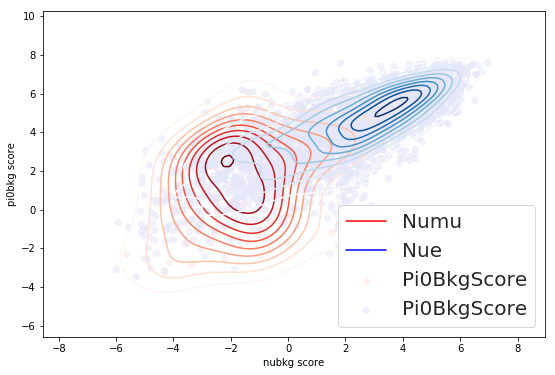

In [18]:
coscut = 'BDTprob > .9'

pi0bkg_nue = df_nue_presel.query(coscut)['Pi0BkgScore']
nubkg_nue = df_nue_presel.query(coscut)['NuBkgScore']
pi0bkg_numu = df_numu_presel.query(coscut)['Pi0BkgScore']
nubkg_numu = df_numu_presel.query(coscut)['NuBkgScore']


fig,ax = plt.subplots(figsize=(9,6))
sns.set_style('ticks')
plt.scatter(nubkg_numu,pi0bkg_numu,color='mistyrose',alpha=.5)
plt.scatter(nubkg_nue,pi0bkg_nue,color='lavender',alpha=.5)
sns.kdeplot(nubkg_numu,pi0bkg_numu,label='Numu',color='red',cmap='Reds')#,cmap="Reds", shade=True, bw=.15)
sns.kdeplot(nubkg_nue,pi0bkg_nue,label='Nue',color='blue',cmap='Blues')#,cmap="Greens", shade=True, bw=.15)

ax.set_xlabel('nubkg score')
ax.set_ylabel('pi0bkg score')
plt.legend(fontsize=20,loc='lower right')


In [19]:
# Now, let's apply cuts.
daviocuts = '(CosBkgScore > 0 and Pi0BkgScore > -(NuBkgScore - 7) * 1.5)'
daviocuts2 = '(CosBkgScore > 3 and Pi0BkgScore > -NuBkgScore*.75 + 8)'


#cuts = 'CosBkgScore > 0 and NuBkgScore > 2'
cuts = 'BDTprob > .8'

df_numu_sel = df_numu_presel.query(cuts)
df_nue_sel = df_nue_presel.query(cuts)
df_ext_sel = df_ext_presel.query(cuts)
df_data_sel = df_data_presel.query(cuts)

weights_numu_sel = df_numu_sel['geniereweight'].values*NUMU_SCALE
weights_nue_sel = df_nue_sel['geniereweight'].values*NUE_SCALE
weights_ext_sel = np.ones(len(df_ext_sel))*EXT_SCALE
weights_data_sel = np.ones(len(df_data_sel))*DATA_SCALE
#weights_lee_sel = df_nue_sel['geniereweight'].values*df_nue_sel['lee_weight'].values*NUE_SCALE

a_weights = [weights_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUE_SCALE,EXT_SCALE]

print len(df_nue_sel)

4610


Events: 17.0
MC:  11.929886205992752


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide


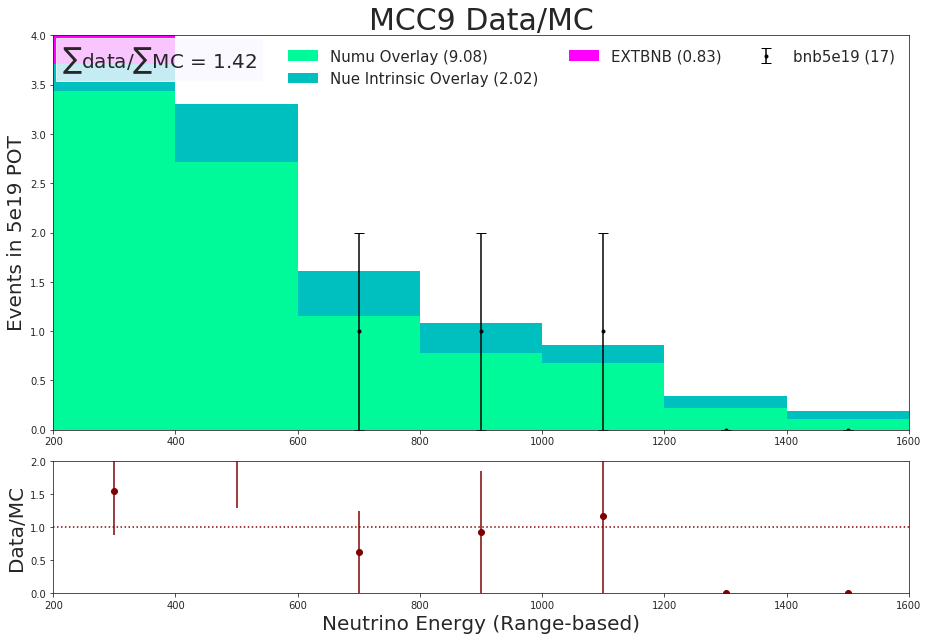

In [20]:
var_numu = df_numu_sel['Enu_1e1p'].values
var_nue = df_nue_sel['Enu_1e1p'].values
var_ext = df_ext_sel['Enu_1e1p'].values
var_data = df_data_sel['Enu_1e1p'].values

fig,ax = plt.subplots(figsize=(13,9))
distplot_wratio(7,(200,1600),[var_numu,var_nue,var_ext],var_data,weights_data_sel,'Neutrino Energy (Range-based)',4e0)
#ax.annotate('All Selection Cuts Applied\nas of August 2019',xy=(.7,.7), xycoords='axes fraction',fontsize=15)
#ax.annotate("Auguz Cuts",xy=(.7,.7), xycoords='axes fraction',fontsize=15)
#ax.annotate('602 Events in 5e19',xy=(.7,.6), xycoords='axes fraction',fontsize=20)

In [36]:
df_offvtx_numu_sel = df_numu_sel.query('scedir_corrected > 5')

df_CCQE_numu_sel = df_numu_sel.query('scedir_corrected <= 5 and interactionType==1001')
df_MEC_numu_sel = df_numu_sel.query('scedir_corrected <= 5 and ineractionMode==10')

pizero = '(interactionType==1090 or interactionType==1086 or interactionType==1090 or interactionType==1015 or interactionType==1013 or interactionType==1011 or interactionType==1008 or interactionType==1006 or interactionType==1004)'
piplus = '(interactionType==1085 or interactionType==1079 or interactionType==1032 or interactionType==1017 or interactionType==1014 or interactionType==1007 or interactionType==1005 or interactionType==1003)'
piminus = '(interactionType==1085 or interactionType==1079 or interactionType==1028 or interactionType==1021 or interactionType==1016 or interactionType==1012 or interactionType==1010 or interactionType==1009)'

df_pizero_numu_sel = df_numu_sel.query('scedir_corrected < 5 and '+pizero)
df_piplusminus_numu_sel = df_numu_sel.query('scedir_corrected < 5 and '+piplus+' or '+piminus)
df_other_numu_sel = df_numu_sel.query('scedir_corrected < 5 and '+'interactionType!=1001 and ineractionMode!=10 and not '+pizero+' and not '+piplus+' and not '+piminus)

NameError: name 'df_numu_sel' is not defined

In [ ]:
#df_CC_numu_sel = df_numu_sel.query(CC)
#df_NC_numu_sel = df_numu_sel.query(NC)

weights_offvtxnumu_sel = np.ones(len(df_offvtx_numu_sel))*NUMU_SCALE
weights_CCQEnumu_sel = df_CCQE_numu_sel['geniereweight'].values*NUMU_SCALE
weights_MECnumu_sel = np.ones(len(df_MEC_numu_sel))*NUMU_SCALE
weights_PIZEROnumu_sel = np.ones(len(df_pizero_numu_sel))*NUMU_SCALE
weights_PIPLUSMINUSnumu_sel = np.ones(len(df_piplusminus_numu_sel))*NUMU_SCALE
weights_OTHERnumu_sel = np.ones(len(df_other_numu_sel))*NUMU_SCALE
weights_nue_sel = df_nue_sel['geniereweight'].values*NUE_SCALE
weights_ext_sel = np.ones(len(df_ext_sel))*EXT_SCALE
weights_data_sel = np.ones(len(df_data_sel))*DATA_SCALE
weights_lee_sel = df_nue_sel['geniereweight'].values*df_nue_sel['lee_weight'].values*NUE_SCALE

In [ ]:
a_weights = [weights_offvtxnumu_sel,weights_CCQEnumu_sel,weights_MECnumu_sel,weights_PIZEROnumu_sel,weights_PIPLUSMINUSnumu_sel,weights_OTHERnumu_sel,weights_nue_sel,weights_lee_sel,weights_ext_sel]
#a_pot = [NUMU_POT,NUMU_POT,NUMU_POT,NUMU_POT,NUMU_POT,NUE_POT,EXT_POT]
a_labels = ['Off Vertex',r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other',r'$\nu_e$ Intrinsic Overlay','LEE','EXTBNB']
a_colors = ['gray','blue','cyan','darkgreen','greenyellow','gold','c','yellow','mediumorchid']

In [ ]:
var_offvtx = df_offvtx_numu_sel['enu_1e1p'].values
var_ccqe = df_CCQE_numu_sel['enu_1e1p'].values
var_mec = df_MEC_numu_sel['enu_1e1p'].values
var_pizero = df_pizero_numu_sel['enu_1e1p'].values
var_piplusminus = df_piplusminus_numu_sel['enu_1e1p'].values
var_other = df_other_numu_sel['enu_1e1p'].values
var_nue = df_nue_sel['enu_1e1p'].values
var_ext = df_ext_sel['enu_1e1p'].values
var_data = df_data_sel['enu_1e1p'].values
fig,ax = plt.subplots(figsize=(13,9))
distplot(8,(0,1600),[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_nue,var_ext],var_data,weights_data_sel,'Neutrino energy',3e0)

ax.annotate('All Selection Cuts Applied\nas of August 2019',xy=(.7,.4), xycoords='axes fraction',fontsize=15)
#ax.annotate("Davio's Selection Cuts",xy=(.7,.4), xycoords='axes fraction',fontsize=15)


In [ ]:
var_offvtx = df_offvtx_numu_sel['eta'].values
var_ccqe = df_CCQE_numu_sel['eta'].values 
var_mec = df_MEC_numu_sel['eta'].values
var_pizero = df_pizero_numu_sel['eta'].values
var_piplusminus = df_piplusminus_numu_sel['eta'].values
var_other = df_other_numu_sel['eta'].values
var_nue = df_nue_sel['eta'].values
var_ext = df_ext_sel['eta'].values
var_data = df_data_sel['eta'].values

fig,ax = plt.subplots(figsize=(13,9))
distplot(30,(0,.8),[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_sel,'Eta',1.3e2)



In [ ]:
vartest = 'bjXB'
var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values

fig,ax = plt.subplots(figsize=(13,9))
distplot(30,(0,2),[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_sel,'Bjorken X Boosted',2e2)

In [ ]:
vartest = 'openAng'
var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values

fig,ax = plt.subplots(figsize=(13,9))
distplot(30,(0,np.pi),[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_sel,'Opening Angle',4e1)

In [ ]:
vartest = 'pT'
var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values

fig,ax = plt.subplots(figsize=(13,9))
distplot(30,(0,1200),[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_sel,'Transverse Momentum',1.3e2)

In [ ]:
vartest = 'pzEnu'
var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values

fig,ax = plt.subplots(figsize=(13,9))
distplot(30,(0,600),[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_sel,'Neutrino Pz',.8e2)

In [ ]:
vartest = 'sphB'
var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values

fig,ax = plt.subplots(figsize=(13,9))
distplot(30,(0,5000),[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_sel,'QE Consistency',1.5e2)

In [ ]:
vartest = 'bjYB'
var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values

fig,ax = plt.subplots(figsize=(13,9))
distplot(30,(0,.001),[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_sel,'Bjorken Y Boosted',1.2e2)

In [ ]:
vartest = 'Proton_ThetaReco'
var_offvtx = np.cos(df_offvtx_numu_sel[vartest].values)
var_ccqe = np.cos(df_CCQE_numu_sel[vartest].values )
var_mec = np.cos(df_MEC_numu_sel[vartest].values)
var_pizero = np.cos(df_pizero_numu_sel[vartest].values)
var_piplusminus = np.cos(df_piplusminus_numu_sel[vartest].values)
var_other = np.cos(df_other_numu_sel[vartest].values)
var_nue = np.cos(df_nue_sel[vartest].values)
var_ext = np.cos(df_ext_sel[vartest].values)
var_data = np.cos(df_data_sel[vartest].values)

fig,ax = plt.subplots(figsize=(13,9))
distplot(30,(-1,1),[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_sel,'Cos (Proton Theta)',3e2)

In [ ]:
vartest = 'Muon_ThetaReco'
var_offvtx = np.cos(df_offvtx_numu_sel[vartest].values)
var_ccqe = np.cos(df_CCQE_numu_sel[vartest].values )
var_mec = np.cos(df_MEC_numu_sel[vartest].values)
var_pizero = np.cos(df_pizero_numu_sel[vartest].values)
var_piplusminus = np.cos(df_piplusminus_numu_sel[vartest].values)
var_other = np.cos(df_other_numu_sel[vartest].values)
var_nue = np.cos(df_nue_sel[vartest].values)
var_ext = np.cos(df_ext_sel[vartest].values)
var_data = np.cos(df_data_sel[vartest].values)

fig,ax = plt.subplots(figsize=(13,9))
distplot(30,(-1,1),[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_sel,'Cos (Muon Theta)',1.5e2)